# Opgaver til Neurale Netværk

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader

from time import perf_counter
np.random.seed(2024)

### Opgave 1: Low-level implementering af et feedforward neuralt netværk
I kapitel 4 i kompendiet introduceres feedforward neurale netværk. I denne opgave skal du implementere et simpelt feedforward neuralt netværk fra bunden ved hjælp af numpy. Bagefter vil vi bruge mere effektive biblioteker som PyTorch til at implementere neurale netværk.

#### Opgave 1.1: Initiering af et neuralt netværk
Nedenunder er givet en kode struktur for at initialisere et neuralt netværk. Udfyld de manglende linjer i koden, således at netværket kan initialiseres med de ønskede antal lag og antal neuroner i hvert lag. Vi antager at alle neuroner skal initieres med tilfældige vægte.

For at afprøve din implementering, skal du bede den endelige kode om at initialisere netværket vist i figur 4.2 i kompendiet. Dette netværk har 2 lag, hvor det første lag har 3 neuroner, og det andet lag har 1 neuron.

In [2]:
def init_vægte(dim_in: int, dim_out: int):
    W = np.random.randn(dim_in, dim_out)
    b = np.random.randn(dim_out)
    return W, b

def init_NN(X_dim: int, L: list[int]):
    vægte = []
    bias = []

    for i, lag in enumerate(L):
        if i == 0:
            W, b = init_vægte(X_dim, lag)
        else:
            W, b = init_vægte(L[i-1], lag)
        vægte.append(W)
        bias.append(b)

    return vægte, bias

In [3]:
def print_NN_params(vægte: list, biases: list):
    print(f"Netværket har {len(vægte)} lag, med hhv. {', '.join([f'{vægte[i].shape[1]} neuroner i lag ({i+1})' for i in range(len(vægte))])}")
    print()
    for i, (vægt, bias) in enumerate(zip(vægte, biases)):
        print(f'W^({i+1}):')
        print(vægt)
        print(f'b^({i+1}):')
        print(bias)
        print()

print_NN_params(*init_NN(X_dim=3, L = [2, 1]))

Netværket har 2 lag, med hhv. 2 neuroner i lag (1), 1 neuroner i lag (2)

W^(1):
[[ 1.66804732  0.73734773]
 [-0.20153776 -0.15091195]
 [ 0.91605181  1.16032964]]
b^(1):
[-2.619962   -1.32529457]

W^(2):
[[0.45998862]
 [0.10205165]]
b^(2):
[1.05355278]



#### Opgave 1.2: Aktiveringsfunktioner
Nedenfor er givet en kode struktur for at implementere nogle af de mest almindelige aktiveringsfunktioner. Udfyld de manglende linjer i koden, således at aktiveringsfunktionerne kan bruges i netværket. Når du mener du har implementeret aktiveringsfunktionerne korrekt, kan du prøve at sammenligne dine resultat-plots i bunden med plotsne på slides. Ligner dine plots dem i kompendiet?

*Hint: Hvis du har brug for hjælp til at implementere aktiveringsfunktionerne, kan du kigge i kapitel 4 i kompendiet eller i slides*

In [4]:
def ReLu(z: np.ndarray, return_derivative: bool = False) -> np.ndarray:
    if return_derivative:
        return np.where(z > 0, 1, 0)
    else:
        return np.maximum(0, z) # TODO: Implementer ReLu

def tanh(z: np.ndarray, return_derivative: bool = False) -> np.ndarray:
    if return_derivative:
        return 1 - tanh(z)**2
    else:
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)) # TODO: Implementer tanh

def sigmoid(z: np.ndarray, return_derivative: bool = False) -> np.ndarray:
    if return_derivative:
        return sigmoid(z) * (1 - sigmoid(z))
    else:
        return 1 / (1 + np.exp(-z)) # TODO: Implementer sigmoid

def leaky_ReLu(z: np.ndarray, alpha: float = 0.1, return_derivative: bool = False) -> np.ndarray:
    if return_derivative:
        return np.where(z > 0, 1, alpha)
    else:
        return np.maximum(alpha * z, z) # TODO: Implementer leaky ReLu

def softmax(z: np.ndarray, return_derivative: bool = False) -> np.ndarray:
    if return_derivative:
        return softmax(z) * (1 - softmax(z))
    else:
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True) # TODO: Implementer softmax

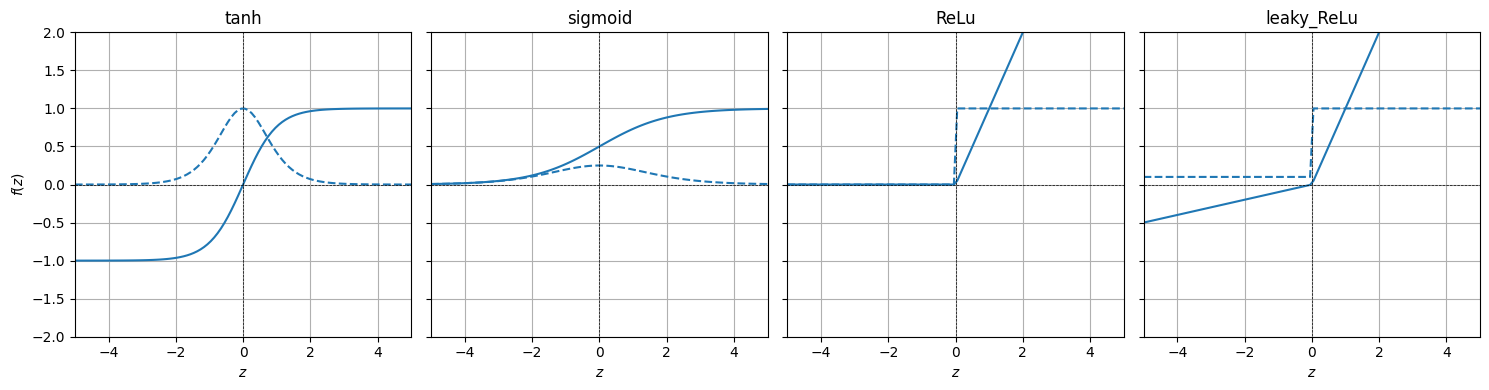

In [5]:
aktiverings_funktioner = [tanh, sigmoid, ReLu, leaky_ReLu]
fig, ax = plt.subplots(1, len(aktiverings_funktioner), figsize=(15, 4), sharey=True, layout='tight')
ax[0].set_ylabel('$f(z)$')
z = np.linspace(-5, 5, 100).reshape(-1, 1)
for i, f in enumerate(aktiverings_funktioner):
    ax[i].plot(z, f(z))
    ax[i].plot(z, f(z, return_derivative=True), '--', color='tab:blue')
    ax[i].set_title(f.__name__)
    ax[i].plot(z, np.zeros_like(z), 'k--', linewidth=0.5)
    ax[i].plot(np.zeros_like(z), z, 'k--', linewidth=0.5)
    ax[i].set_ylim([-2, 2])
    ax[i].set_xlim([-5, 5])
    ax[i].grid(True)
    ax[i].set_xlabel('$z$')
plt.show()

#### Opgave 1.3: Forward pass
Vi er nu klar til at koble netværket sammen. I kompendiet benævnte vi grunden bag at feed forward netværk hedder feed forward; Informationen rejser forward igennem netværket. Nedenfor er givet en kode struktur for at implementere et **forward pass** i et neuralt netværk. Udfyld de manglende linjer i koden, således at forward pass kan udføres. Når du mener du har implementeret forward pass korrekt, kan du prøve at køre understående kode, der initialisere et netværk og benytter de forskellige aktiveringsfunktioner og udfører et forward pass med inputtet

$$\mathbf{X}=\begin{bmatrix} 0.5 & 0.1 \\ 0.4 & 2.1 \\ -1.0 & -0.8 \\ 0.6 & -1.9 \end{bmatrix}$$

Hvilket output får du? Hvis du tænker over dimensionerne på inputtet, dimensionerne på outputtet og de forskellige aktiveringsfunktioner, kan du så forklare hvorfor du får det output du får og hvad outputtet fortæller dig?

In [6]:
def forward(X: np.ndarray, vægte: list, biases: list, aktiverings_funks: list) -> np.ndarray:
    a = X
    for i, (W, b, f) in enumerate(zip(vægte, biases, aktiverings_funks)):
        z = np.dot(a, W) + b
        a = f(z)
    return a

In [7]:
X = np.array([[0.2, 0.8], [2.5, 3], [0.3, -0.9],[4, 3.5]])
vægte, biases = init_NN(X_dim=2, L=[3, 3, 3, 3, 2])
fs = [tanh, ReLu, leaky_ReLu, ReLu, softmax]
print(forward(X, vægte, biases, fs))

[[0.9107918  0.0892082 ]
 [0.93363803 0.06636197]
 [0.99892213 0.00107787]
 [0.92982782 0.07017218]]


#### Opgave 1.4: Klassifikation
I denne opgave skal du implementere en klassifikationsfunktion, som kan bruges til at klassificere outputtet fra netværket. Koden er givet nedenfor. Udfyld de manglende linjer i koden, således at klassifikationsfunktionen kan bruges til at klassificere outputtet fra netværket. Når du mener du har implementeret klassifikationsfunktionen korrekt, kan du prøve at køre koden derunder. Hvilke af de fire datapunkter i $\mathbf{X}$ klassificeres som klasse 1 og hvilke klassificeres som klasse 2?

In [8]:
def get_label(prob: np.ndarray) -> np.ndarray:
    return np.argmax(prob, axis=1)

Klassifikation: [0 0 0 0]


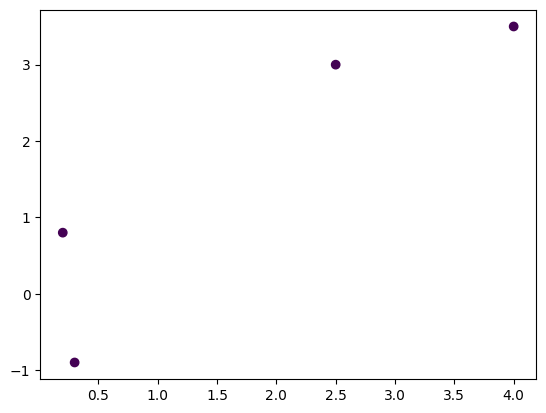

In [9]:
y_prob = forward(X, vægte, biases, fs)
y = get_label(y_prob)
print(f"Klassifikation: {y}")
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Ikke overraskende er det neurale netværk ikke særlig god til at klassificere data, da vi ikke har trænet netværket endnu. I næste opgave skal vi træne netværket.

#### Opgave 1.5: Loss funktion
For at kunne træne netværket, må vi starte med at implementere loss functionen. Nedenfor er givet en kode struktur for at implementere en række forskellige loss funktioner som de blev set til forelæsningen:
* Mean-squared error (MSE)
* Mean-absolute error (MAE)
* Categorical Cross Entropy (CCE)
* Binary Cross Entropy (BCE)

Udfyld de manglende linjer i koden, således at loss funktionerne kan bruges i netværket. Hvilken loss funktion til hvilken type problem?

In [106]:
def MSE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred)**2)

def MAE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(np.abs(y_true - y_pred))

def CCE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def BCE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

#### Opgave 1.6: Fuldt eksempel
Prøv i følgende at ændre lidt på vægtene og beregn loss med CCE. Hvor lille loss kan du få?

Først er der lidt kode til at plotte og lave data:

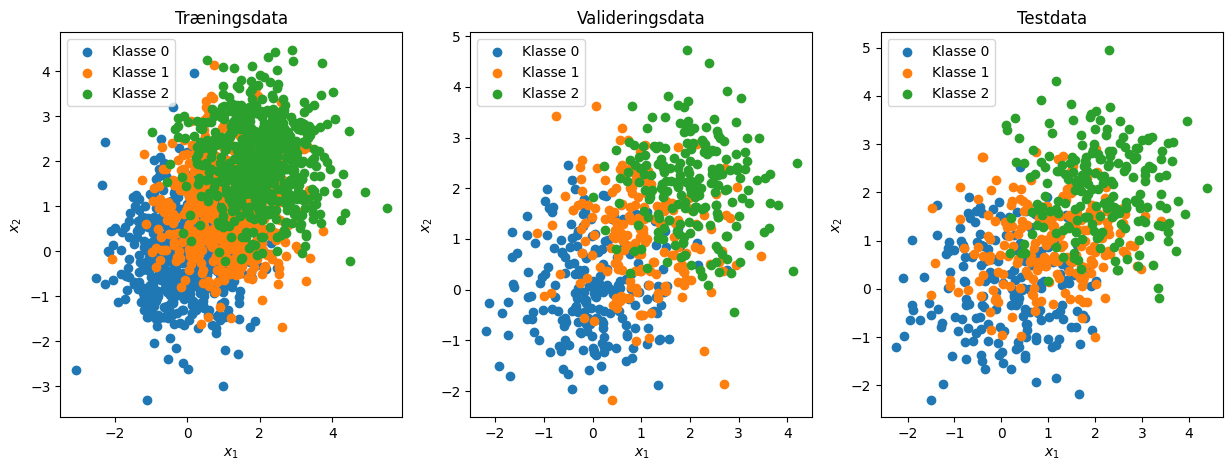

In [11]:
def data_generator(n_datapunkter: int = 3000, n_klasser: int = 3, n_dim: int = 2, støj: float = 0.9):
    for klasse in range(n_klasser):
        X_ = np.random.normal(klasse, støj, (n_datapunkter // n_klasser, n_dim))
        y_ = np.full(X_.shape[0], klasse)
        if klasse == 0:
            X = X_
            y = y_
        else:
            X = np.vstack([X, X_])
            y = np.hstack([y, y_])

    idx = np.random.permutation(X.shape[0])
    X, y = X[idx], y[idx]
    X_train, y_train = X[:int(0.6 * X.shape[0])], y[:int(0.6 * X.shape[0])]
    X_val, y_val = X[int(0.6 * X.shape[0]):int(0.8 * X.shape[0])], y[int(0.6 * X.shape[0]):int(0.8 * X.shape[0])]
    X_test, y_test = X[int(0.8 * X.shape[0]):], y[int(0.8 * X.shape[0]):]
    return X_train, y_train, X_val, y_val, X_test, y_test  

def plot_data(X: np.ndarray, y: np.ndarray, axs: plt.Axes = None):
    if axs is None:
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    for klasse in np.unique(y):
        axs.scatter(X[y == klasse, 0], X[y == klasse, 1], label=f'Klasse {klasse}')
    axs.legend()

X_train, y_train, X_val, y_val, X_test, y_test = data_generator()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, x, y in zip(range(3), [X_train, X_val, X_test], [y_train, y_val, y_test]):
    plot_data(x, y, ax[i])
    ax[i].set_title(['Træningsdata', 'Valideringsdata', 'Testdata'][i])
    ax[i].set_xlabel('$x_1$')
    ax[i].set_ylabel('$x_2$')
plt.show()

In [120]:
# Sæt vægte her
def forward(X: np.ndarray, vægte: list, biases: list, aktiverings_funks: list) -> np.ndarray:
    n_layers = len(vægte)
    a = X
    activations = np.zeros(n_layers + 1, dtype=object)
    activations[0] = X
    zs = np.zeros(n_layers, dtype=object)

    for layer, (W, b, f) in enumerate(zip(vægte, biases, aktiverings_funks)):
        z = np.dot(a, W) + b
        zs[layer] = z
        a = f(z)
        activations[layer + 1] = a
    return activations, zs

def backward(y_true, activations, zs, vægte, biases, aktiverings_funks):
    deltas = [None] * len(vægte)
    grads_w = [None] * len(vægte)
    grads_b = [None] * len(biases)

    # Compute the delta for the last layer
    delta = activations[-1] - y_true
    deltas[-1] = delta

    # Backpropagate the error
    for l in range(len(vægte)-2, -1, -1):
        delta = np.dot(delta, vægte[l+1].T) * aktiverings_funks[l](zs[l], return_derivative=True)
        deltas[l] = delta

    # Compute gradients
    for l in range(len(vægte)):
        grads_w[l] = np.dot(activations[l].T, deltas[l])
        grads_b[l] = np.sum(deltas[l], axis=0, keepdims=True)

    return grads_w, grads_b

def update_parameters(vægte, biases, grads_w, grads_b, learning_rate):
    for l in range(len(vægte)):
        vægte[l] -= learning_rate * grads_w[l]
        biases[l] -= (learning_rate * grads_b[l]).reshape(-1)
    
    return vægte, biases

def train(X, y, vægte, biases, aktiverings_funks, epochs, learning_rate):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # One-hot encode y_true_train and y_true_val
    N_klasser = np.unique(y).shape[0]
    N_samples = y.shape[0]

    y_true_one_hot = np.zeros((N_samples, N_klasser))
    y_true_one_hot[np.arange(len(y)), y] = 1
    y_val_one_hot = np.zeros((y_val.shape[0], N_klasser))
    y_val_one_hot[np.arange(len(y_val)), y_val] = 1

    for epoch in range(epochs):
        activations, zs = forward(X, vægte, biases, aktiverings_funks)
        grads_w, grads_b = backward(y_true_one_hot, activations, zs, vægte, biases, aktiverings_funks)

        # Evaluate the loss
        train_loss = CCE(y_true_one_hot, activations[-1])
        train_losses.append(train_loss)
        train_accuracies.append(np.mean(get_label(activations[-1]) == y))

        val_activations, _ = forward(X_val, vægte, biases, aktiverings_funks)
        val_loss = CCE(y_val_one_hot, val_activations[-1])
        val_losses.append(val_loss)
        val_accuracies.append(np.mean(get_label(val_activations[-1]) == y_val))

        vægte, biases = update_parameters(vægte, biases, grads_w, grads_b, learning_rate)
        if epoch % 5 == 0:
            print(f'Epoch {epoch}{" " if len(str(epoch)) == 1 else ""} ### Train Loss: {train_loss} ### Val Loss: {val_loss}')
    
    metrics = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    return vægte, biases, metrics

(2, 10)
(10, 10)
(10, 10)
(10, 3)
Epoch 0  ### Train Loss: 26.20894685002195 ### Val Loss: 25.033895946355425
Epoch 5  ### Train Loss: 0.9996652680410951 ### Val Loss: 0.9505917585003771
Epoch 10 ### Train Loss: 0.8288000966698501 ### Val Loss: 0.7847768740615165
Epoch 15 ### Train Loss: 0.7990167042691801 ### Val Loss: 0.7673068572566092
Epoch 20 ### Train Loss: 0.7876563982523129 ### Val Loss: 0.759663645148465
Epoch 25 ### Train Loss: 0.7775343480986251 ### Val Loss: 0.7508741317996519


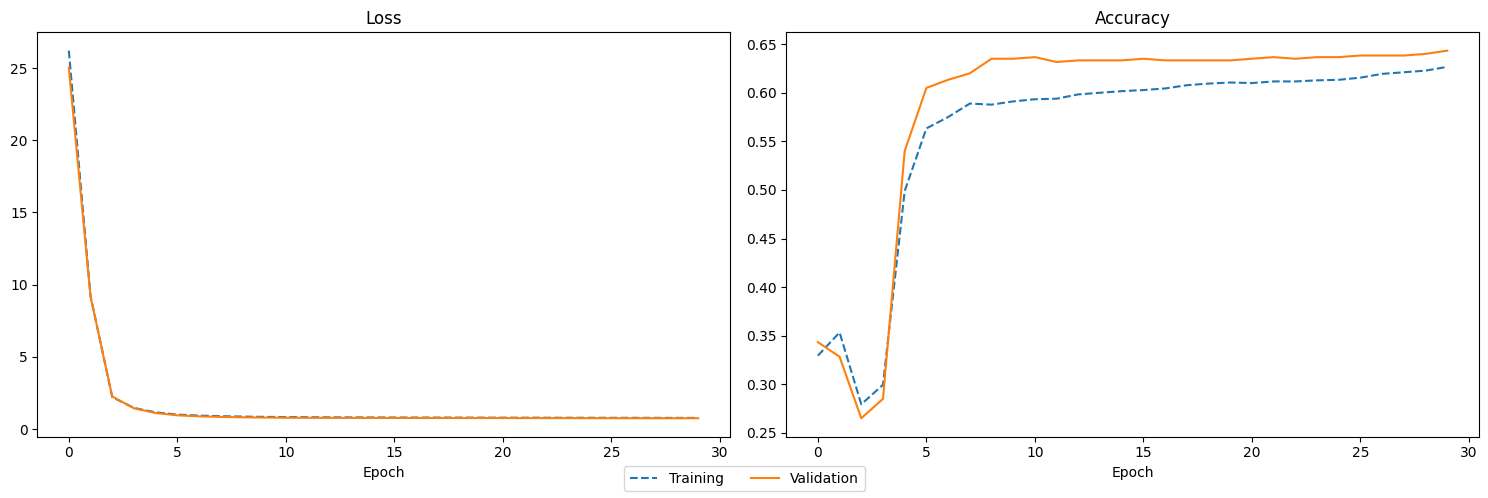

In [122]:
X_dim = X_train.shape[1]
L = [10, 10, 10, 3]
vægte, biases = init_NN(X_dim, L)
fs = [ReLu, leaky_ReLu, ReLu, softmax]

[print(vægt.shape) for vægt in vægte]

# Choose hyperparameters
epochs = 30
learning_rate = 0.0001

vægte, biases, metrics = train(X_train, y_train, vægte, biases, fs, epochs=epochs, learning_rate=learning_rate)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), layout='tight')
ax[0].plot(metrics['train_losses'], label='Training', linestyle='--', color='tab:blue')
ax[0].plot(metrics['val_losses'], label='Validation', color='tab:orange')
ax[0].set_title("Loss")

ax[1].plot(metrics['train_accuracies'], label='Training', linestyle='--', color='tab:blue')
ax[1].plot(metrics['val_accuracies'], label='Validation', color='tab:orange')
ax[1].set_title("Accuracy")

for a in ax:
    a.set_xlabel('Epoch')

# shared legend below the plots
lines, labels = ax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=2)
plt.show()

### Opgave 2: Implementering af et neuralt netværk med PyTorch

Det ovenstående eksempel var en god øvelse i at forstå hvordan neurale netværk fungerer, men i praksis vil vi ofte bruge mere effektive biblioteker til at implementere neurale netværk. I denne opgave skal du implementere det samme neurale netværk med PyTorch. Du skal bruge PyTorch til at initialisere et neuralt netværk, udføre et forward pass, beregne loss, udføre et backward pass og opdatere vægtene i netværket. Du skal bruge PyTorch til at initialisere et neuralt netværk, udføre et forward pass, beregne loss, udføre et backward pass og opdatere vægtene i netværket.

Vi bruger det samme data som forrige opgave:

In [112]:
BATCH_SIZE = 64

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()),
    batch_size= BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()),
    batch_size= BATCH_SIZE,
    shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()),
    batch_size= BATCH_SIZE,
    shuffle=True
)

#### Opgave 2.1

I følgende kan i se et eksempel på et simpelt neuralt netværk. Dette er implementeret ved hjælp af PyTorch biblioteket. I følgende opgaver vil i blive bedt om at lave nogle ændringer i dette netværk for at ændre dets struktur.

In [113]:
# definer netværket
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        # Loss funktionen
        self.criterion = nn.CrossEntropyLoss()

        # De to lag der bruges. Det første argument er hvor mange neuroner der er i det forrige lag. 
        # Det andet argument er hvor mange der skal være i det nuværrende lag
        self.l1 = nn.Linear(num_features,6)
        self.l2 = nn.Linear(6,num_classes)

    def forward(self, x):
        # Hvordan netværket skal køres:
        x = self.l1(x) # Lag 1
        x = F.relu(x) # Aktiveringsfunktion for lag 1
        x = self.l2(x) # Lag 2
        output = F.softmax(x, dim=1) # Aktiveringsfunktion for lag 2 (softmax)
        return output

#Hyperparameters
num_classes = torch.from_numpy(y_train).unique().shape[0]
num_features = X_train.shape[1]
epochs = 10

Nedenfor følger træningsløkken. I bør ikke ændre noget i denne. Det vigtigeste her er at funktionen træner jeres model og viser hvordan den klare sig:

In [114]:
def train(train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, model):
    """
    Træner modellen
    Args:
    train_loader (torch.utils.data.DataLoader): DataLoader for træningsdata
    val_loader (torch.utils.data.DataLoader): DataLoader for valideringsdata
    model (torch.nn.Module): Netværksarkitektur
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    optimizer = optim.SGD(model.parameters())
    his_acc = []
    his_val_acc = []
    his_loss = []
    his_val_loss = []

    for epoch in range(epochs):
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        # Sæt model til træning
        model.train()
        start_time = perf_counter()
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.float().to(device), y.long().to(device)

            # Genstart gradienter
            optimizer.zero_grad()

            # Forward pass
            y_hat_prob = model(X)
            y_hat = torch.argmax(y_hat_prob, dim=1).long()
            
            # Beregn loss, accuracy, og validation accuracy
            loss = model.criterion(y_hat_prob, y)
            losses.append(loss.item())
            accuracy = torch.sum(y_hat == y) / len(y)
            accuracies.append(accuracy)

            # Backward pass og opdatering af vægte
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for batch, (X, y) in enumerate(val_loader):
                X, y = X.float().to(device), y.long().to(device)
                y_hat_prob = model(X)
                val_loss = model.criterion(y_hat_prob, y)
                val_losses.append(val_loss.item())
                val_accuracy = torch.sum(torch.argmax(y_hat_prob, dim=1) == y) / len(y)
                val_accuracies.append(val_accuracy)

            end_time = perf_counter()
            his_acc.append(sum(accuracies) / len(accuracies))
            his_val_acc.append(sum(val_accuracies) / len(val_accuracies))

            his_loss.append(sum(losses) / len(losses))
            his_val_loss.append(sum(val_losses) / len(val_losses))
            print(f"[{epoch+1} / {epochs} {end_time-start_time:.2f}s] Training - Loss: {sum(losses) / len(losses):3f} Accuracy: {sum(accuracies) / len(accuracies):3f} | Validation - Loss: {sum(val_losses) / len(val_losses):3f} Accuracy: {sum(val_accuracies) / len(val_accuracies):3f}")
    plt.figure()
    plt.plot(range(epochs), his_acc, 'r', range(epochs), his_val_acc, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('Epochs'), plt.ylabel('Acc')
    plt.show()

    plt.plot(range(epochs), his_loss, 'r', range(epochs), his_val_loss, 'b')
    plt.legend(['Train Loss','Validation Loss'])
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.show()


    


Vi kan nu træne hvores simple model og se hvordan den klare sig på datasættet. Kør koden og se hvordna den træningen forløber. Se om i kan finde hvor mange epochs som modellen skal køre for at nogenlunde stibilisere i loss og accuracy.

[1 / 500 0.04s] Training - Loss: 1.103405 Accuracy: 0.339978 | Validation - Loss: 1.108359 Accuracy: 0.309896
[2 / 500 0.02s] Training - Loss: 1.103142 Accuracy: 0.339978 | Validation - Loss: 1.108392 Accuracy: 0.309896
[3 / 500 0.01s] Training - Loss: 1.103103 Accuracy: 0.339978 | Validation - Loss: 1.110141 Accuracy: 0.302083
[4 / 500 0.01s] Training - Loss: 1.103790 Accuracy: 0.336207 | Validation - Loss: 1.109142 Accuracy: 0.304688
[5 / 500 0.01s] Training - Loss: 1.102537 Accuracy: 0.339978 | Validation - Loss: 1.108633 Accuracy: 0.307292
[6 / 500 0.01s] Training - Loss: 1.104553 Accuracy: 0.332435 | Validation - Loss: 1.107626 Accuracy: 0.312500
[7 / 500 0.01s] Training - Loss: 1.103699 Accuracy: 0.332435 | Validation - Loss: 1.105731 Accuracy: 0.317708
[8 / 500 0.01s] Training - Loss: 1.101269 Accuracy: 0.347522 | Validation - Loss: 1.108972 Accuracy: 0.304688
[9 / 500 0.01s] Training - Loss: 1.102446 Accuracy: 0.339978 | Validation - Loss: 1.108456 Accuracy: 0.302083
[10 / 500 

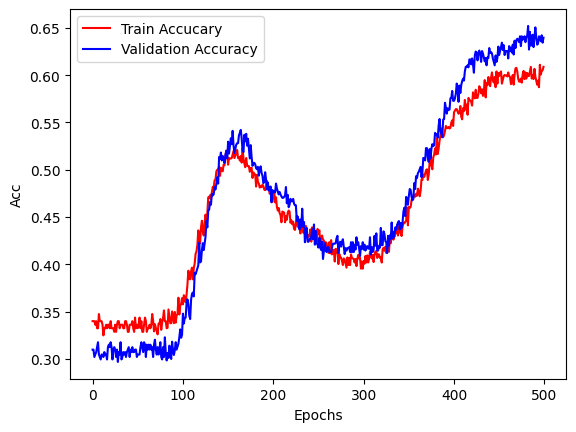

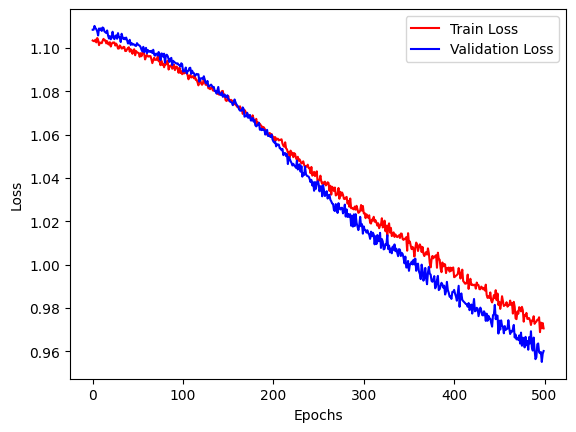

In [115]:
epochs = 500
net = Net(num_features, num_classes)
train(train_loader,val_loader,net)

#### Opgave 2.2

På følgende netværk, ændrer antallet af neuroner i det midterste lag til at være 15 neuroner, og se hvordan det ændre på modellens loss og performance

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        # Loss funktionen
        self.criterion = nn.CrossEntropyLoss()

        # De to lag der bruges. Det første argument er hvor mange neuroner der er i det forrige lag. 
        # Det andet argument er hvor mange der skal være i det nuværrende lag
        self.l1 = nn.Linear(num_features,6)
        self.l2 = nn.Linear(6,num_classes)

    def forward(self, x):
        # Hvordan netværket skal køres:
        x = self.l1(x) # Lag 1
        x = F.relu(x) # Aktiveringsfunktion for lag 1
        x = self.l2(x) # Lag 2
        output = F.softmax(x, dim=1) # Aktiveringsfunktion for lag 2 (softmax)
        return output


In [ ]:
net = Net(num_features, num_classes)
# Skriv koden til at træne her
epochs = 500
train(train_loader,val_loader,net)

#### Opgave 2.3
På følgende netværk, ændre aktiveringsfunktionen til at være en sigmoid:

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        # Loss funktionen
        self.criterion = nn.CrossEntropyLoss()

        # De to lag der bruges. Det første argument er hvor mange neuroner der er i det forrige lag. 
        # Det andet argument er hvor mange der skal være i det nuværrende lag
        self.l1 = nn.Linear(num_features,6)
        self.l2 = nn.Linear(6,num_classes)

    def forward(self, x):
        # Hvordan netværket skal køres:
        x = self.l1(x) # Lag 1
        x = F.relu(x) # Aktiveringsfunktion for lag 1
        x = self.l2(x) # Lag 2
        output = F.softmax(x, dim=1) # Aktiveringsfunktion for lag 2 (softmax)
        return output


In [ ]:
#Skriv koden til at træne her

#### Opgave 2.4
På følgende netværk tilføj et ekstra lag. Husk at tilføje en aktiveringsfunktion.

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        # Loss funktionen
        self.criterion = nn.CrossEntropyLoss()

        # De to lag der bruges. Det første argument er hvor mange neuroner der er i det forrige lag. 
        # Det andet argument er hvor mange der skal være i det nuværrende lag
        self.l1 = nn.Linear(num_features,6)
        self.l2 = nn.Linear(6,num_classes)

    def forward(self, x):
        # Hvordan netværket skal køres:
        x = self.l1(x) # Lag 1
        x = F.relu(x) # Aktiveringsfunktion for lag 1
        x = self.l2(x) # Lag 2
        output = F.softmax(x, dim=1) # Aktiveringsfunktion for lag 2 (softmax)
        return output


In [ ]:
#Skriv koden til at træne her

#### Opgave 2.5
Implementer at følgende netværk tager en ekstra parameter L. Dette skal være antallet af lag i netværket:

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes, L):
        super(Net, self).__init__()
        # Loss funktionen
        self.criterion = nn.CrossEntropyLoss()

        # De to lag der bruges. Det første argument er hvor mange neuroner der er i det forrige lag. 
        # Det andet argument er hvor mange der skal være i det nuværrende lag
        self.l1 = nn.Linear(num_features,6)
        self.l2 = nn.Linear(6,num_classes)

    def forward(self, x):
        # Hvordan netværket skal køres:
        x = self.l1(x) # Lag 1
        x = F.relu(x) # Aktiveringsfunktion for lag 1
        x = self.l2(x) # Lag 2
        output = F.softmax(x, dim=1) # Aktiveringsfunktion for lag 2 (softmax)
        return output


In [ ]:
#Skriv koden til at træne her

#### Opgave 2.6
Lav en større model. Den skal have 6 lag med følgende struktur:
1. `num_features` neuroner og ReLU aktiveringsfunktion
2. 17 neuroner og sigmoid akriveringsfunktion
3. 7 neuroner og ReLU aktiveringsfunktion
4. 32 neuroner og tanh aktiveringsfunktion
5. 16 neuroner og ReLU aktiveringsfunktion
6. `num_classes` neuroner og softmax aktiveringsfunktion

In [ ]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        # Loss funktionen
        self.criterion = nn.CrossEntropyLoss()

        # De to lag der bruges. Det første argument er hvor mange neuroner der er i det forrige lag. 
        # Det andet argument er hvor mange der skal være i det nuværrende lag
        self.l1 = nn.Linear(num_features,6)
        self.l2 = nn.Linear(6,num_classes)

    def forward(self, x):
        # Hvordan netværket skal køres:
        x = self.l1(x) # Lag 1
        x = F.relu(x) # Aktiveringsfunktion for lag 1
        x = self.l2(x) # Lag 2
        output = F.softmax(x, dim=1) # Aktiveringsfunktion for lag 2 (softmax)
        return output


In [ ]:
#Skriv koden til at træne her